# Search Engine with Sastrawi

Search engine is a software system that seeks web pages matching a user's search query. Currently, text processing in the Indonesian language is becoming increasingly crucial to enhance the quality of search results. Sastrawi is a library for natural language processing (NLP) in the Indonesian language that can be utilized to optimize search engine outcomes. In its application, Sastrawi can assist in the data preprocessing process, such as stemming, stopword removal, and tokenization, thereby improving the quality of search results in the Indonesian language. Therefore, the use of Sastrawi in preprocessing can serve as a solution to enhance the quality of searches in the Indonesian language on search engines.

# Import the Libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import string
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Create Some Functions

## Load Data Function

The provided Python function, named `load_data`, is designed to fetch and process popular news articles from a specified source link. It utilizes the `requests` library to retrieve the HTML content of the source link and then uses `BeautifulSoup` for HTML parsing. The function extracts the links of popular news articles from a specific div class on the webpage, appends `?page=all` to each link to ensure complete page retrieval, and stores them in a list called `link`. Subsequently, it iterates through these links, retrieves the HTML content for each article, and extracts the text content from the paragraphs within a designated div class. The function compiles these texts into a list named `documents`. Finally, it creates a Pandas DataFrame with a single column named `news` containing the compiled document texts. Overall, the function aims to facilitate the loading and structuring of popular news articles from the provided source link for further analysis.

In [2]:
def load_data(source_link):
    # Fetching popular news links
    r = requests.get(source_link)
    soup = BeautifulSoup(r.content, 'html.parser')

    link = []
    for i in soup.find('div', {'class':'most__wrap'}).find_all('a'):
        i['href'] = i['href'] + '?page=all'
        link.append(i['href'])

    # Fetching documents from each link
    documents = []
    for i in link:
        r = requests.get(i)
        soup = BeautifulSoup(r.content, 'html.parser')

        sen = []
        for j in soup.find('div', {'class':'read__content'}).find_all('p'):
            sen.append(j.text)
        documents.append(' '.join(sen))

    dataframe = pd.DataFrame({'news': documents})
    return dataframe

## Preprocess Text Function

The provided Python function, `preprocess_text`, serves to clean and preprocess a given text string, offering options to remove stopwords and perform lemmatization. Initially, the function uses regular expressions to eliminate non-ASCII characters, mentions (e.g., Twitter handles), and punctuation, converting the text to lowercase. Additionally, it removes numerical digits and extra whitespaces. The function then provides the option to further enhance text quality by removing stopwords using the Sastrawi library, which is specifically designed for the Indonesian language. Furthermore, it tokenizes the text using the NLTK library, and if lemmatization is specified, it employs Sastrawi for stemming to reduce words to their base form. Finally, the processed tokens are joined into a clean and normalized text string, ready for subsequent analysis or natural language processing tasks. Overall, the function offers a flexible and comprehensive text preprocessing pipeline catering to different linguistic needs.

In [3]:
def preprocess_text(text: str, remove_stopwords: bool, lemmatize: bool) -> str:
    # Cleaning text
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'@\w+', '', text)
    text = text.lower()
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'[0-9]', '', text)
    text = re.sub(r'\s{2,}', ' ', text)

    # Remove stop words using Sastrawi
    if remove_stopwords:
        stopword_factory = StopWordRemoverFactory()
        stopword_remover = stopword_factory.create_stop_word_remover()
        text = stopword_remover.remove(text)

    # Tokenization with NLTK
    tokens = word_tokenize(text)

    # "Stemming with Sastrawi
    if lemmatize:
        stemmer_factory = StemmerFactory()
        stemmer = stemmer_factory.create_stemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    text = " ".join(tokens).lower().strip()
    return text

## TF IDF Function

The provided Python function, named `tf_idf`, implements the Term Frequency-Inverse Document Frequency (TF-IDF) vectorization technique for text data. Given a set of search keys, a DataFrame (`dataframe`), and a specified label indicating the column containing textual data, the function utilizes the `TfidfVectorizer` from scikit-learn to transform the text data into a TF-IDF weights matrix. This matrix represents the importance of each term in the context of the entire corpus. Additionally, the function calculates the TF-IDF weights for the search keys using the same vectorizer. The result is a tuple containing the TF-IDF weights matrix for the entire dataset and the TF-IDF weights for the provided search keys. This function is valuable for information retrieval and text analysis tasks, enabling the comparison of the importance of terms in the dataset against a specific search query.

In [4]:
def tf_idf(search_keys, dataframe, label):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_weights_matrix = tfidf_vectorizer.fit_transform(dataframe.loc[:, label])
    search_query_weights = tfidf_vectorizer.transform([search_keys.lower()])
    return search_query_weights, tfidf_weights_matrix

## Cosine Similarity Function

The provided function, named `cos_similarity`, calculates the cosine similarity between a given search query represented by its weights and a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) weights. The function utilizes the `cosine_similarity` function from a relevant library, presumably like scikit-learn. It computes the cosine distance between the search query and each document in the TF-IDF matrix, resulting in a list of similarity scores. The function then returns this list, where each score represents the cosine similarity between the search query and the corresponding document in the TF-IDF-weighted matrix. This type of similarity measure is commonly employed in information retrieval and natural language processing to assess the similarity between textual data, aiding tasks such as document retrieval or text matching.

In [5]:
def cos_similarity(search_query_weights, tfidf_weights_matrix):
    cosine_distance = cosine_similarity(search_query_weights, tfidf_weights_matrix)
    similarity_list = cosine_distance[0]
    return similarity_list

## Most Similar Function

The provided Python function, named `most_similar`, is designed to identify and return the indices and corresponding cosine similarity values of the most similar items from a given similarity list. The function takes two parameters: `similarity_list`, representing a list of cosine similarity values between items, and `min_talks`, which sets the minimum number of similar items to be identified (default is 1). The function iteratively identifies the index with the highest cosine similarity, appends it to the `most_similar_indices` list, records the corresponding similarity value in `cosine_similarity_values`, and then sets the similarity value at that index to zero to avoid selecting the same item again. This process continues until the specified minimum number of similar items (`min_talks`) is reached. The function then returns the list of indices and their corresponding cosine similarity values. Overall, the function provides a simple yet effective way to find the most similar items based on cosine similarity from a given list.

In [6]:
def most_similar(similarity_list, min_talks=1):
    most_similar_indices = []
    cosine_similarity_values = []

    while min_talks > 0:
        tmp_index = np.argmax(similarity_list)
        most_similar_indices.append(tmp_index)
        cosine_similarity_values.append(similarity_list[tmp_index])
        similarity_list[tmp_index] = 0
        min_talks -= 1

    return most_similar_indices, cosine_similarity_values

# Collect the Data

The provided code snippet initializes a variable `news_source_link` with the URL 'https://health.kompas.com/'. Subsequently, it calls the `load_data` function with this URL as an argument, aiming to retrieve and process popular health news articles from the specified source. The resulting data is stored in a Pandas DataFrame named `data`.

In [7]:
news_source_link = 'https://tekno.kompas.com/'
data = load_data(news_source_link)
data

,news
0,KOMPAS.com - Samsung Galaxy F62 dinobatkan se...
1,KOMPAS.com - Situs pencarian dan pemesanan hot...
2,KOMPAS.com - Huawei resmi meluncurkan tablet k...
3,KOMPAS.com - Tanggal peluncuran resmi ponsel k...
4,KOMPAS.com - Samsung resmi meluncurkan ponsel ...
5,KOMPAS.com - WhatsApp atau biasa disingkat WA...
6,KOMPAS.com - Xiaomi bersiap merilis antarmuka ...
7,KOMPAS.com - Pabrikan smartphone Vivo baru-bar...
8,KOMPAS.com - Xiaomi merilis smartphone terbaru...
9,KOMPAS.com - Pengembang game asal Amerika Seri...


# Applying Search Engine to Search Query in KOMPAS Web

## Unpreprocesssed Data

In this step, we will compare search engine experiments with unprocessed data. The difference lies in not preprocessing the search queries in one case and preprocessing them in the other. The key distinction is the absence of preprocessing for one set of search queries and the inclusion of preprocessing for the other.

In [8]:
# Input search query
search_query = input("Enter search query: ")

# TF-IDF (without preprocessing on search queries)
result = tf_idf(search_query, data, 'news')
search_query_weights, tfidf_weights_matrix = result

# Cosine Similarity
result_cosine = cos_similarity(search_query_weights, tfidf_weights_matrix)

# Most Similar Documents
result_most_indices, cosine_similarity_values = most_similar(result_cosine, min_talks=len(data))

# Output
print(f"\nSearch Query: {search_query}")

# List to save results
document_numbers_1 = []
cosine_similarity_values_list_1 = []

# Display non-zero similarity documents
print(f"\nAll documents with non-zero similarity to '{search_query}':")

for i, index in enumerate(result_most_indices):
    document_number_1 = index + 1  # The document number corresponds to the index
    cosine_similarity_value_1 = cosine_similarity_values[i]

    # Displays documents with a similarity value other than 0
    if cosine_similarity_value_1 > 0:
        document_numbers_1.append(document_number_1)
        cosine_similarity_values_list_1.append(cosine_similarity_value_1)

        news_content_1 = data.loc[index, 'news']
        print(f"\nDocument Number {document_number_1}:")
        print(f"Cosine Similarity: {cosine_similarity_value_1}")
        print('='*40)

Enter search query: apa saja produk andalan samsung yang terbaru?

Search Query: apa saja produk andalan samsung yang terbaru?

All documents with non-zero similarity to 'apa saja produk andalan samsung yang terbaru?':

Document Number 5:
Cosine Similarity: 0.28702578075090723

Document Number 1:
Cosine Similarity: 0.257972570310377

Document Number 7:
Cosine Similarity: 0.0515475923880349

Document Number 10:
Cosine Similarity: 0.04677416495038459

Document Number 9:
Cosine Similarity: 0.03787554276910312

Document Number 6:
Cosine Similarity: 0.02791243203394584

Document Number 3:
Cosine Similarity: 0.026022365594209524

Document Number 8:
Cosine Similarity: 0.02449782962405605

Document Number 2:
Cosine Similarity: 0.016541941597319195

Document Number 4:
Cosine Similarity: 0.005026720301412185


In [9]:
# Input search query
search_query = input("Enter search query: ")

# Preprocess search query
search_query_preprocessed = preprocess_text(search_query, remove_stopwords=True, lemmatize=True)

# TF-IDF (with preprocessing on search queries)
result = tf_idf(search_query_preprocessed, data, 'news')
search_query_weights, tfidf_weights_matrix = result

# Cosine Similarity
result_cosine = cos_similarity(search_query_weights, tfidf_weights_matrix)

# Most Similar Documents
result_most_indices, cosine_similarity_values = most_similar(result_cosine, min_talks=len(data))

# Output
print(f"\nSearch Query: {search_query_preprocessed}")

# List to save results
document_numbers_2 = []
cosine_similarity_values_list_2 = []

# Display non-zero similarity documents
print(f"\nAll documents with non-zero similarity to '{search_query_preprocessed}':")

for i, index in enumerate(result_most_indices):
    document_number_2 = index + 1  # The document number corresponds to the index
    cosine_similarity_value_2 = cosine_similarity_values[i]

    # Displays documents with a similarity value other than 0
    if cosine_similarity_value_2 > 0:
        document_numbers_2.append(document_number_2)
        cosine_similarity_values_list_2.append(cosine_similarity_value_2)

        news_content_2 = data.loc[index, 'news']
        print(f"\nDocument Number {document_number_2}:")
        print(f"Cosine Similarity: {cosine_similarity_value_2}")
        print('='*40)

Enter search query: apa saja produk andalan samsung yang terbaru?

Search Query: produk andal samsung baru

All documents with non-zero similarity to 'produk andal samsung baru':

Document Number 5:
Cosine Similarity: 0.34451240703420294

Document Number 1:
Cosine Similarity: 0.27531443532511246

Document Number 7:
Cosine Similarity: 0.03808980437694616

Document Number 8:
Cosine Similarity: 0.015216274844896847

Document Number 6:
Cosine Similarity: 0.008461324204980218

Document Number 9:
Cosine Similarity: 0.005740761794228925

Document Number 4:
Cosine Similarity: 0.004464624116091756


## Preprocessed Data

In this next phase, we are introducing preprocessing to our data. Before conducting any comparisons, we perform preprocessing on the `news` column. The process involves tasks like removing stopwords and lemmatizing the text. Subsequently, a new column named `news_cleaned` is added to the DataFrame `data`, containing the cleaned and preprocessed text. This step is essential for enhancing the quality of the data and enabling a more accurate and insightful comparison with the unprocessed data.

In [10]:
data['news_cleaned'] = data['news'].apply(lambda x: preprocess_text(x, remove_stopwords=True, lemmatize=True))
data

,news,news_cleaned
0,KOMPAS.com - Samsung Galaxy F62 dinobatkan se...,kompas com samsung galaxy nobat handphone hp s...
1,KOMPAS.com - Situs pencarian dan pemesanan hot...,kompas com situs cari mesan hotel tiket transp...
2,KOMPAS.com - Huawei resmi meluncurkan tablet k...,kompas com huawei resmi luncur tablet kelas fl...
3,KOMPAS.com - Tanggal peluncuran resmi ponsel k...,kompas com tanggal luncur resmi ponsel kelas t...
4,KOMPAS.com - Samsung resmi meluncurkan ponsel ...,kompas com samsung resmi luncur ponsel baru sa...
5,KOMPAS.com - WhatsApp atau biasa disingkat WA...,kompas com whatsapp singkat wa gelontor fitur ...
6,KOMPAS.com - Xiaomi bersiap merilis antarmuka ...,kompas com xiaomi rilis antarmuka user interfa...
7,KOMPAS.com - Pabrikan smartphone Vivo baru-bar...,kompas com pabrikan smartphone vivo luncur ang...
8,KOMPAS.com - Xiaomi merilis smartphone terbaru...,kompas com xiaomi rilis smartphone baru redmi ...
9,KOMPAS.com - Pengembang game asal Amerika Seri...,kompas com kembang game amerika serikat santa ...


In [17]:
# Input search query
search_query = input("Enter search query: ")

# TF-IDF (tanpa preprocessing pada search query)
result = tf_idf(search_query, data, 'news_cleaned')
search_query_weights, tfidf_weights_matrix = result

# Cosine Similarity
result_cosine = cos_similarity(search_query_weights, tfidf_weights_matrix)

# Most Similar Documents
result_most_indices, cosine_similarity_values = most_similar(result_cosine, min_talks=len(data))

# Output
print(f"\nSearch Query: {search_query}")

# List untuk menyimpan hasil
document_numbers_3 = []
cosine_similarity_values_list_3 = []

# Display non-zero similarity documents
print(f"\nAll documents with non-zero similarity to '{search_query}':")

for i, index in enumerate(result_most_indices):
    document_number_3 = index + 1  # Nomor dokumen sesuai dengan indeks
    cosine_similarity_value_3 = cosine_similarity_values[i]

    # Menampilkan dokumen dengan nilai kemiripan selain 0
    if cosine_similarity_value_3 > 0:
        document_numbers_3.append(document_number_3)
        cosine_similarity_values_list_3.append(cosine_similarity_value_3)

        news_content_3 = data.loc[index, 'news']
        print(f"\nDocument Number {document_number_3}:")
        print(f"Cosine Similarity: {cosine_similarity_value_3}")
        print('='*40)

Enter search query: apa saja produk andalan samsung yang terbaru?

Search Query: apa saja produk andalan samsung yang terbaru?

All documents with non-zero similarity to 'apa saja produk andalan samsung yang terbaru?':

Document Number 5:
Cosine Similarity: 0.5157531328983459

Document Number 1:
Cosine Similarity: 0.3410482684682059

Document Number 7:
Cosine Similarity: 0.03903058329494876


In [12]:
# Input search query
search_query = input("Enter search query: ")

# Preprocess search query
search_query_preprocessed = preprocess_text(search_query, remove_stopwords=True, lemmatize=True)

# TF-IDF (tanpa preprocessing pada search query)
result = tf_idf(search_query_preprocessed, data, 'news_cleaned')
search_query_weights, tfidf_weights_matrix = result

# Cosine Similarity
result_cosine = cos_similarity(search_query_weights, tfidf_weights_matrix)

# Most Similar Documents
result_most_indices, cosine_similarity_values = most_similar(result_cosine, min_talks=len(data))

# Output
print(f"\nSearch Query: {search_query_preprocessed}")

# List untuk menyimpan hasil
document_numbers_4 = []
cosine_similarity_values_list_4 = []

# Display non-zero similarity documents
print(f"\nAll documents with non-zero similarity to '{search_query_preprocessed}':")

for i, index in enumerate(result_most_indices):
    document_number_4 = index + 1  # Nomor dokumen sesuai dengan indeks
    cosine_similarity_value_4 = cosine_similarity_values[i]

    # Menampilkan dokumen dengan nilai kemiripan selain 0
    if cosine_similarity_value_4 > 0:
        document_numbers_4.append(document_number_4)
        cosine_similarity_values_list_4.append(cosine_similarity_value_4)

        news_content_4 = data.loc[index, 'news']
        print(f"\nDocument Number {document_number_4}:")
        print(f"Cosine Similarity: {cosine_similarity_value_4}")
        print('='*40)

Enter search query: apa saja produk andalan samsung yang terbaru?

Search Query: produk andal samsung baru

All documents with non-zero similarity to 'produk andal samsung baru':

Document Number 5:
Cosine Similarity: 0.43350346928143135

Document Number 1:
Cosine Similarity: 0.2717622651550927

Document Number 7:
Cosine Similarity: 0.03110128596811403

Document Number 8:
Cosine Similarity: 0.014667576652164763

Document Number 3:
Cosine Similarity: 0.01440494923324518

Document Number 9:
Cosine Similarity: 0.009880075478057714

Document Number 6:
Cosine Similarity: 0.005812689659467747


# Exploration

The code below creates four models (`model_1`, `model_2`, `model_3`, and `model_4`) containing pairs of document numbers and their respective cosine similarity values. Subsequently, a DataFrame named `result_df` is constructed with columns representing document numbers and the cosine similarity values from each model. The code fills in the DataFrame by matching document numbers and populating corresponding cosine similarity values from each model. Finally, a new DataFrame named `sorted_df` is generated by sorting the `result_df` based on the `Document Number` column, and the sorted DataFrame is displayed.

In summary, the code below efficiently organizes and compares cosine similarity values from four different models for a set of document numbers, providing a clear and structured output for analysis.

In [13]:
model_1 = list(zip(document_numbers_1, cosine_similarity_values_list_1))
model_2 = list(zip(document_numbers_2, cosine_similarity_values_list_2))
model_3 = list(zip(document_numbers_3, cosine_similarity_values_list_3))
model_4 = list(zip(document_numbers_4, cosine_similarity_values_list_4))

# Membuat dataframe
columns = ['Document Number', 'Model 1', 'Model 2', 'Model 3', 'Model 4']
result_df = pd.DataFrame(columns=columns)

# Mengisi dataframe dengan nilai dari keempat model
result_df['Document Number'] = [i[0] for i in model_1]
result_df['Model 1'] = [i[1] for i in model_1]
result_df['Model 2'] = [next((i[1] for i in model_2 if i[0] == doc), 0) for doc in result_df['Document Number']]
result_df['Model 3'] = [next((i[1] for i in model_3 if i[0] == doc), 0) for doc in result_df['Document Number']]
result_df['Model 4'] = [next((i[1] for i in model_4 if i[0] == doc), 0) for doc in result_df['Document Number']]

# Membuat dataframe yang diurutkan berdasarkan 'Document Number'
sorted_df = result_df.sort_values(by='Document Number')

# Menampilkan dataframe yang diurutkan
print(sorted_df)

   Document Number   Model 1   Model 2   Model 3   Model 4
1                1  0.257973  0.275314  0.341048  0.271762
8                2  0.016542  0.000000  0.000000  0.000000
6                3  0.026022  0.000000  0.000000  0.014405
9                4  0.005027  0.004465  0.000000  0.000000
0                5  0.287026  0.344512  0.515753  0.433503
5                6  0.027912  0.008461  0.000000  0.005813
2                7  0.051548  0.038090  0.039031  0.031101
7                8  0.024498  0.015216  0.000000  0.014668
4                9  0.037876  0.005741  0.000000  0.009880
3               10  0.046774  0.000000  0.000000  0.000000


This code below extracts four lists (`both_unpreprocessed`, `only_search_query_preprocessed`, `only_data_preprocessed`, and `both_preprocessed`) from the sorted DataFrame, representing different combinations of preprocessed and unprocessed data for cosine similarity values. It includes a function, `average_without_zeros(lst)`, to compute the average cosine similarity without considering zero values. The function is then applied to each list, yielding the average cosine similarity for the corresponding scenarios. Overall, the code succinctly captures and analyzes the effectiveness of different models in measuring document similarities.

In [14]:
# List dari DataFrame yang telah diurutkan
both_unpreprocessed = sorted_df['Model 1'].tolist()
only_search_query_preprocessed = sorted_df['Model 2'].tolist()
only_data_preprocessed = sorted_df['Model 3'].tolist()
both_preprocessed = sorted_df['Model 4'].tolist()

# Fungsi untuk menghitung rata-rata tanpa nilai 0
def average_without_zeros(lst):
    values = [value for value in lst if value != 0]
    return np.mean(values) if values else 0

# Menghitung nilai rata-rata tanpa menghitung nilai 0
average_both_unpreprocessed = average_without_zeros(both_unpreprocessed)
average_only_search_query_preprocessed = average_without_zeros(only_search_query_preprocessed)
average_only_data_preprocessed = average_without_zeros(only_data_preprocessed)
average_both_preprocessed = average_without_zeros(both_preprocessed)

# Visualization

The provided code generates a comparative visualization of cosine similarity values for different scenarios using a bar chart. The document numbers serve as labels on the x-axis, while the y-axis represents cosine similarity. Each document number has four corresponding bars, each with a distinct color representing different preprocessing conditions: unprocessed data (yellow), search query only preprocessed (light green), data only preprocessed (light blue), and both preprocessed (light coral). Additionally, the chart includes horizontal lines indicating the average cosine similarity for each condition. This visualization enables a clear comparison of the impact of preprocessing on cosine similarity values across various scenarios, enhancing the understanding of the model performances.

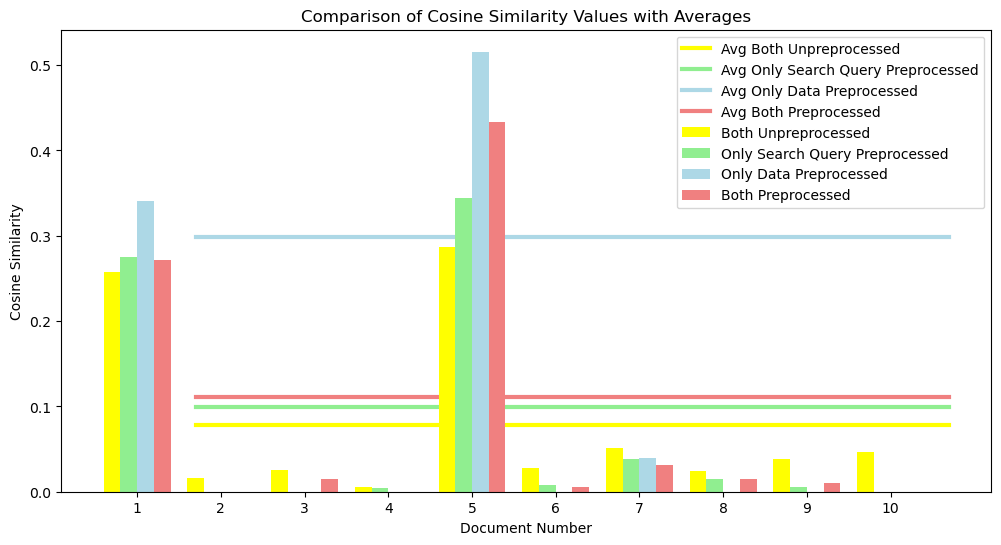

In [15]:
# List of labels from the 'Document Number' column
labels = sorted_df['Document Number'].tolist()

# Bar chart with different colors for each condition
plt.figure(figsize=(12, 6))
bar_width = 0.2
bar_positions = np.arange(len(labels))

plt.bar(bar_positions, both_unpreprocessed, color='yellow', width=bar_width, label='Both Unpreprocessed', zorder=2)
plt.bar(bar_positions + bar_width, only_search_query_preprocessed, color='lightgreen', width=bar_width, label='Only Search Query Preprocessed', zorder=2)
plt.bar(bar_positions + 2*bar_width, only_data_preprocessed, color='lightblue', width=bar_width, label='Only Data Preprocessed', zorder=2)
plt.bar(bar_positions + 3*bar_width, both_preprocessed, color='lightcoral', width=bar_width, label='Both Preprocessed', zorder=2)

# Line chart for average with matching colors
plt.plot(labels, [average_both_unpreprocessed] * len(labels), color='yellow', label='Avg Both Unpreprocessed', linewidth=3, zorder=1)
plt.plot(labels, [average_only_search_query_preprocessed] * len(labels), color='lightgreen', label='Avg Only Search Query Preprocessed', linewidth=3, zorder=1)
plt.plot(labels, [average_only_data_preprocessed] * len(labels), color='lightblue', label='Avg Only Data Preprocessed', linewidth=3, zorder=1)
plt.plot(labels, [average_both_preprocessed] * len(labels), color='lightcoral', label='Avg Both Preprocessed', linewidth=3, zorder=1)

# Customize the chart
plt.xlabel('Document Number')
plt.ylabel('Cosine Similarity')
plt.title('Comparison of Cosine Similarity Values with Averages')
plt.legend()

# Set x-axis ticks at the center of each group
plt.xticks(bar_positions + 1.5*bar_width, labels)

plt.show()

# Displaying Top Document to Analysis the Result

The code below aims to display the top three documents from the best-performing model, facilitating an analysis of whether the search query aligns with the presented documents. Initially, the variable `top_n` is set to 3, indicating the number of top documents to be shown. The code then sorts the indices based on cosine similarity values in descending order and iterates through the top N documents, extracting relevant information such as document number, cosine similarity value, and news content. This information is stored in a list called `top_documents`. Subsequently, the code prints the document number, cosine similarity, and news content for each of the top N documents. The ultimate goal of this code is to provide a concise and insightful analysis of how well the search query corresponds to the displayed documents from the best model.

In [18]:
# Best Model
top_n = 3  # Number of top documents to display
top_documents = []

# Sort the indices based on cosine similarity values
sorted_indices = sorted(enumerate(cosine_similarity_values), key=lambda x: x[1], reverse=True)

# Display the top N documents
for i in range(top_n):
    index = sorted_indices[i][0]
    document_number_3 = result_most_indices[index] + 1
    cosine_similarity_value_3 = cosine_similarity_values[index]
    
    news_content_3 = data.loc[result_most_indices[index], 'news']
    
    top_documents.append({
        'Document Number': document_number_3,
        'Cosine Similarity': cosine_similarity_value_3,
        'News Content': news_content_3
    })

# Print the top N documents
for doc in top_documents:
    print(f"\nDocument Number {doc['Document Number']}:")
    print(f"Cosine Similarity: {doc['Cosine Similarity']}")
    print(f"{doc['News Content']}\n{'='*50}\n")


Document Number 5:
Cosine Similarity: 0.5157531328983459
KOMPAS.com - Samsung resmi meluncurkan ponsel terbarunya, Samsung Galaxy A15 4G dan Samsung Galaxy A15 5G di Vietnam, Selasa (12/12/2023). Duo smartphone ini merupakan penerus dari Samsung Galaxy A14 4G dan 5G yang dirilis pada awal 2023. Samsung A15 4G dan Samsung A15 5G adalah HP kembar secara desain dan spesifikasi. Perbedaannya terletak pada sektor chipset atau System-on-Chip (SoC). Samsung Galaxy A15 4G mengandalkan SoC delapan inti (octa-core) MediaTek Helio G99 dengan clockspeed maksimum 2,2 GHz. Sementara Samsung Galaxy A15 5G diotaki chipset octa-core MediaTek Dimensity 6100 Plus dengan clockspeed yang sama, yakni 2,2 GHz. Di luar urusan chipset, baik Samsung Galaxy A15 4G dan Samsung Galaxy A15 5G memiliki spesifikasi dan desain yang identik. Samsung A15 4G dan Samsung A15 5G mengusung layar Super AMOLED 6,5 inci dengan resolusi Full HD Plus (1.080 x 2.340 piksel), refresh rate 90 Hz, dan tingkat kecerahan (brightness)